# Modelling Ambient Temperature for Synthetic Data Generation

Firstly, we load the JSON file with the meteorological data for the area where the transformers are located for the year 2023, from which we want to generate the synthetic profile.

In [1]:
import json
import csv

In [2]:
fich = json.load(open("almonte_2023_diario.json"))

In [3]:
len(fich)

365

In [4]:
outname = "almonte_2023_temp_diaria.csv"
with open(outname, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["fecha", "tmax_C", "hora_tmax", "tmin_C", "hora_tmin"])
    for rec in fich:
        fecha = rec.get("fecha")
        tmax = float(rec.get("tmax").replace(",", ".")) if rec.get("tmax") else None
        hora_tmax = rec.get("horatmax")
        tmin = float(rec.get("tmin").replace(",", ".")) if rec.get("tmin") else None
        hora_tmin = rec.get("horatmin")
        writer.writerow([fecha, tmax, hora_tmax, tmin, hora_tmin])

Next, we propose different methods to generate an annual temperature series that meets the continuity of the temperature function.

## Interpolation with Cubic Splines

This method consists of interpolating the available maximum and minimum temperature values using splines.

In [5]:
from scipy.interpolate import CubicSpline, make_interp_spline
import numpy as np
import pandas as pd

In [6]:
temp_df = pd.read_csv('/Users/alzorrcarri/Documents/resisto_synth/synthetic_model/temperature_ambience/almonte_2023_temp_diaria.csv', na_values=['nan', 'Varias', ''])

In [7]:
temp_df.head()

,fecha,tmax_C,hora_tmax,tmin_C,hora_tmin
0,2023-01-01,21.1,14:21,6.3,03:59
1,2023-01-02,16.0,00:01,11.1,23:54
2,2023-01-03,17.3,14:39,5.7,07:48
3,2023-01-04,18.6,14:43,7.4,02:22
4,2023-01-05,18.8,15:23,6.0,06:20


In [8]:
# Fill missing values
temp_df.loc[temp_df['hora_tmax'].isna(), 'hora_tmax'] = '15:00'
temp_df.loc[temp_df['hora_tmin'].isna(), 'hora_tmin'] = '05:00'

In [9]:
aux = temp_df['tmax_C'].to_numpy()
aux[np.isnan(aux)] = np.mean(aux, where=~np.isnan(aux))
temp_df['tmax_C'] = aux

aux = temp_df['tmin_C'].to_numpy()
aux[np.isnan(aux)] = np.mean(aux, where=~np.isnan(aux))
temp_df['tmin_C'] = aux

In [10]:
temp_df.to_csv('/Users/alzorrcarri/Documents/resisto_synth/synthetic_model/temperature_ambience/almonte_2023_temp_diaria_filled.csv', index=False)

In [11]:
# Build up an array with min and max temperatures interleaved
temp_array = np.empty((temp_df.shape[0]*2,), dtype=float)
temp_array[0::2] = temp_df['tmin_C']
temp_array[1::2] = temp_df['tmax_C']

As a first approach, we consider that the maximum and minimum temperatures occur at the same hours of the day throughout the year.

In [12]:
# Build up an array of times (in days) corresponding to daily max and min temperature data
tiempos = np.arange(0, len(temp_df)*2) * 0.5 + 0.2 # Every day at 0.2 and 0.7 hours

In [13]:
cs = CubicSpline(tiempos, temp_array)

In [14]:
# Generate Ta for fine time points (e.g., every hour: 1/24 days)
tiempos_finos = np.linspace(tiempos[0], tiempos[-1], len(tiempos) * 24)
ta_suavizada = cs(tiempos_finos)

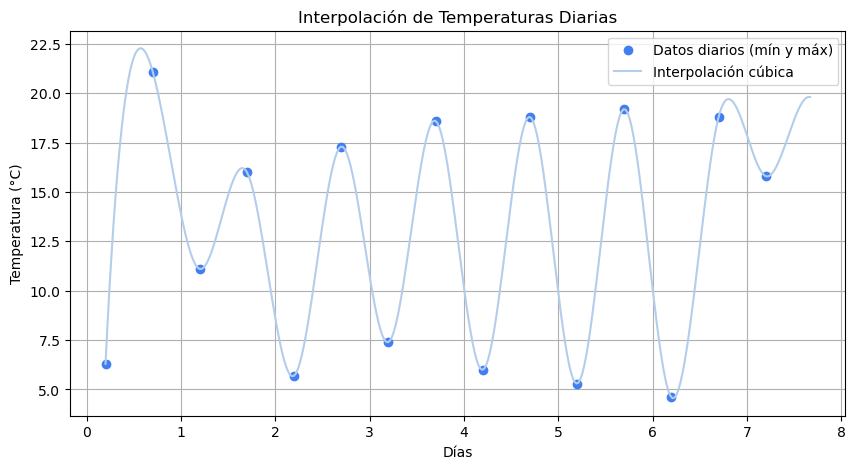

In [15]:
# Graphic representation
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(tiempos[0:15], temp_array[0:15], 'o', label='Datos diarios (mín y máx)', color='#417EF0')
plt.plot(tiempos_finos[0:15*24], ta_suavizada[0:15*24], '-', label='Interpolación cúbica', color='#B3CDEA')
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.title('Interpolación de Temperaturas Diarias')
plt.legend()
plt.grid()
plt.show()

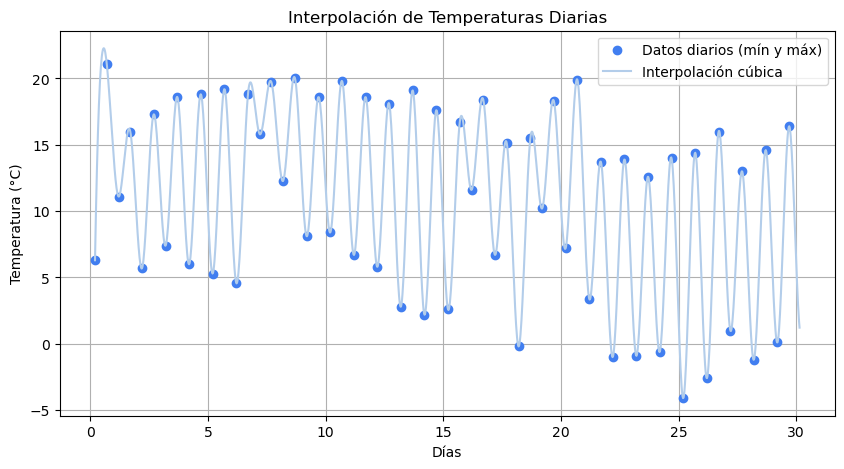

In [16]:
# Graphic representation (extended to show more data)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(tiempos[0:15*4], temp_array[0:15*4], 'o', label='Datos diarios (mín y máx)', color='#417EF0')
plt.plot(tiempos_finos[0:15*24*4], ta_suavizada[0:15*24*4], '-', label='Interpolación cúbica', color='#B3CDEA')
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.title('Interpolación de Temperaturas Diarias')
plt.legend()
plt.grid()
plt.show()

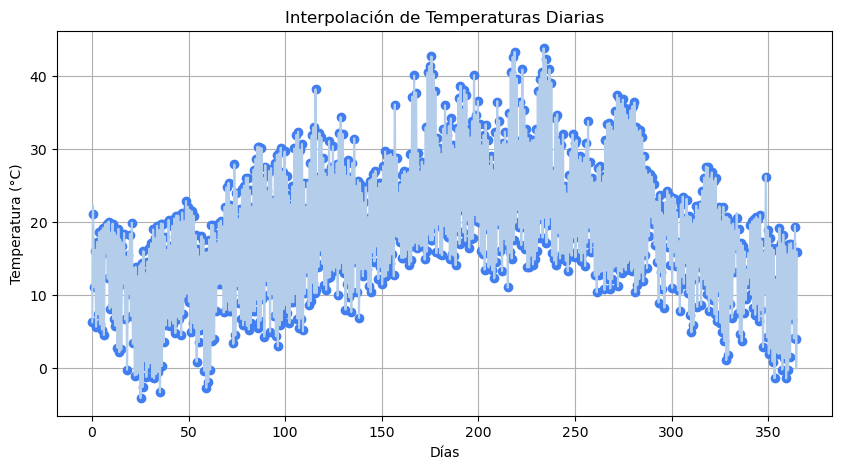

In [17]:
# Graphic representation (full data)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(tiempos, temp_array, 'o', label='Datos diarios (mín y máx)', color='#417EF0')
plt.plot(tiempos_finos, ta_suavizada, '-', label='Interpolación cúbica', color='#B3CDEA')
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.title('Interpolación de Temperaturas Diarias')
# plt.legend()
plt.grid()
plt.show()

Considering now the times of day at which the maximum and minimum temperatures occur when making the splines.

In [18]:
def parse_time_to_fraction(time_str):
    """Convert a 'HH:MM' time string to a fraction of the day."""
    hours, minutes = map(int, time_str.split(":"))
    return hours / 24 + minutes / 1440

In [19]:
tiempos = np.empty((temp_df.shape[0]*2,), dtype=float)
tiempos[0::2] = temp_df['hora_tmin'].apply(parse_time_to_fraction) + temp_df.index
tiempos[1::2] = temp_df['hora_tmax'].apply(parse_time_to_fraction) + temp_df.index

In [20]:
orden = np.argsort(tiempos)
tiempos = tiempos[orden]
temp_array = temp_array[orden]

In [21]:
cs = CubicSpline(tiempos, temp_array)

In [22]:
tiempos_finos = np.linspace(tiempos[0], tiempos[-1], len(tiempos) * 24)
ta_suavizada = cs(tiempos_finos)

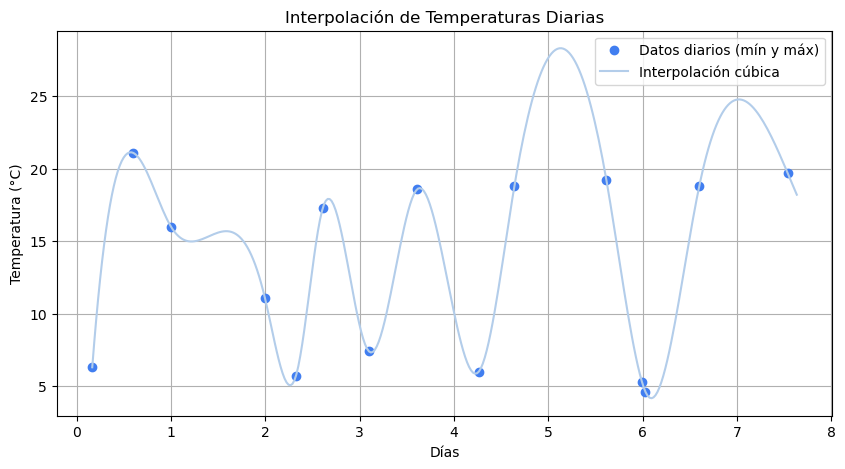

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(tiempos[0:15], temp_array[0:15], 'o', label='Datos diarios (mín y máx)', color='#417EF0')
plt.plot(tiempos_finos[0:15*24], ta_suavizada[0:15*24], '-', label='Interpolación cúbica', color='#B3CDEA')
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.title('Interpolación de Temperaturas Diarias')
plt.legend()
plt.grid()
plt.show()

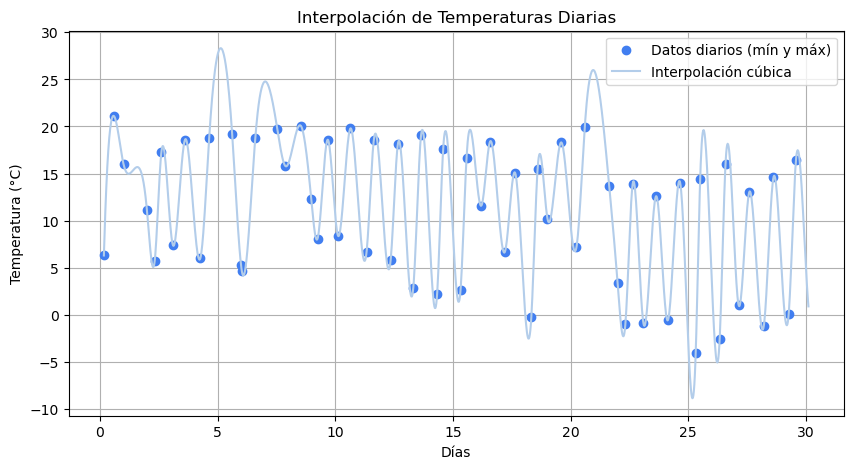

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(tiempos[0:15*4], temp_array[0:15*4], 'o', label='Datos diarios (mín y máx)', color='#417EF0')
plt.plot(tiempos_finos[0:15*24*4], ta_suavizada[0:15*24*4], '-', label='Interpolación cúbica', color='#B3CDEA')
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.title('Interpolación de Temperaturas Diarias')
plt.legend()
plt.grid()
plt.show()

Now, instead of using cubic splines, we use linear splines (we maintain continuity of the temperature function).

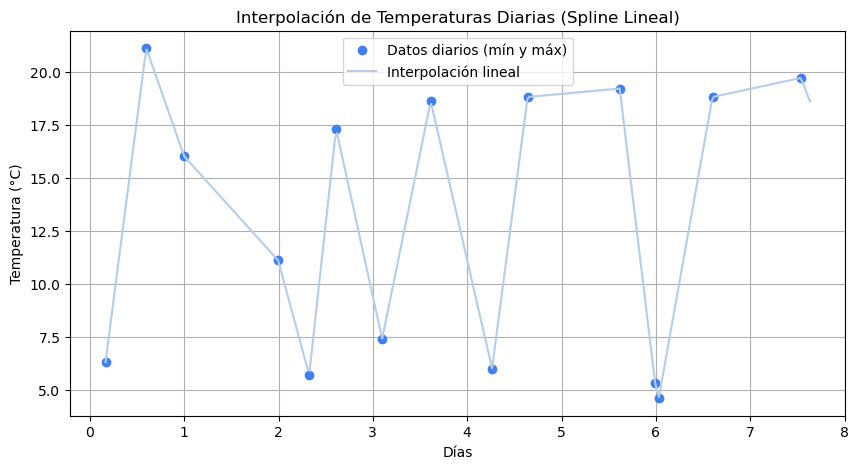

In [25]:
ls = make_interp_spline(tiempos, temp_array, k=1)  # k=1 for lineal spline

tiempos_finos = np.linspace(tiempos[0], tiempos[-1], len(tiempos) * 24)
ta_suavizada = ls(tiempos_finos)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(tiempos[0:15], temp_array[0:15], 'o', label='Datos diarios (mín y máx)', color='#417EF0')
plt.plot(tiempos_finos[0:15*24], ta_suavizada[0:15*24], '-', label='Interpolación lineal', color='#B3CDEA')
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.title('Interpolación de Temperaturas Diarias (Spline Lineal)')
plt.legend()
plt.grid()
plt.show()

## Physical Sinusoidal Model

Two **cubic splines** are performed with the **daily mean temperatures** and the **daily thermal amplitudes**. A **sinusoidal wave**, which is **phase-shifted** to adjust its maximum to the time of maximum temperature and **moderated** by the thermal amplitude, is added to the behavior of the mean temperature. Therefore, we generate a **synthetic annual profile** following the formula:

$$T_{\text{amb}} (t) = T_{\text{spline}} (t) + A_{\text{spline}} (t) \sin{\left ( \frac{2\pi}{24} (t - \phi) \right )}$$

We consider that the **maximum temperature** occurs every day at **15:00 hours**.


/var/folders/lp/8xhvbnh90j7366cnys2gjhq00000gn/T/ipykernel_14737/2735559782.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2023-01-01 00:00', '2023-01-02 00:00', '2023-01-03 00:00', '2023-01-04 00:00', '2023-01-05 00:00',


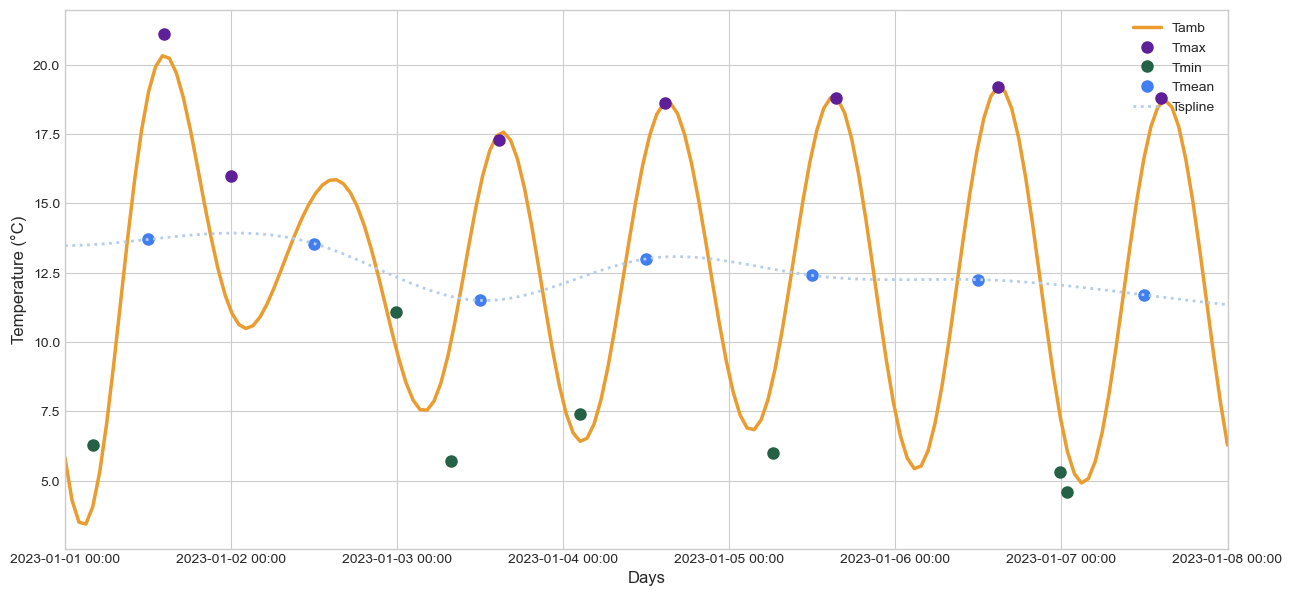

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# --- 1. INPUT DATA ---
total_days = 7
# Now we provide the maximum and minimum temperatures for each of the total_days.
T_daily_maximas = temp_df['tmax_C'].to_numpy()[0:total_days]
T_daily_minimas = temp_df['tmin_C'].to_numpy()[0:total_days]


# --- 2. PHYSICAL MODEL PARAMETERS ---
# The time of the temperature peak remains a parameter to be defined.
peak_temperature_hour = 15.0 # 3 PM

# --- 3. CALCULATION OF DAILY MEANS AND AMPLITUDES ---
# We calculate the mean and amplitude for each day from the data.
T_calculated_means = (T_daily_maximas + T_daily_minimas) / 2
Calculated_Amplitudes = (T_daily_maximas - T_daily_minimas) / 2

# --- 4. CREATION OF SMOOTH BASELINES (TWO SPLINES) ---
x_midpoints = np.arange(total_days) + 0.5

# Spline for the mean temperature
mean_spline = CubicSpline(x_midpoints, T_calculated_means, bc_type='natural')
# Spline for the amplitude
amplitude_spline = CubicSpline(x_midpoints, Calculated_Amplitudes, bc_type='natural')

# Generate a high-resolution time scale
continuous_t = np.linspace(0, total_days, total_days * 24)

# Calculate the continuous values for the base and the amplitude
T_smooth_base = mean_spline(continuous_t)
A_smooth = amplitude_spline(continuous_t)


# --- 5. ADD THE SINUSOIDAL DAILY VARIATION (WITH VARIABLE AMPLITUDE) ---
phi = peak_temperature_hour - 6
hours_of_day = (continuous_t * 24) % 24
T_daily_variation = A_smooth * np.sin( (2 * np.pi / 24) * (hours_of_day - phi) )


# --- 6. OBTAIN THE FINAL AMBIENT TEMPERATURE ---
T_final_ambient = T_smooth_base + T_daily_variation


# --- 7. VISUALIZATION OF RESULTS ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))

# Final profile
ax.plot(continuous_t, T_final_ambient, 
        label='Tamb', 
        color='#EA9C2F', 
        linewidth=2.5)

# Original Tmax and Tmin points for verification
time_min = (temp_df['hora_tmin'].apply(parse_time_to_fraction) + temp_df.index).to_numpy()[0:total_days]
time_max = (temp_df['hora_tmax'].apply(parse_time_to_fraction) + temp_df.index).to_numpy()[0:total_days]

ax.plot(time_max, T_daily_maximas, 'o', color='#5E1F99', markersize=8, label='Tmax')
ax.plot(time_min, T_daily_minimas, 'o', color='#256146', markersize=8, label='Tmin')
ax.plot(x_midpoints, T_calculated_means, 'o', color='#417EF0', markersize = 8, label='Tmean')

# Baseline curves for reference
ax.plot(continuous_t, T_smooth_base, 
        label='Tspline', 
        color='#B3CDEA', 
        linestyle=':', 
        linewidth=2)

ax.set_xlabel('Days', fontsize=12)
ax.set_xlim(0, total_days)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)
ax.set_xticklabels(['2023-01-01 00:00', '2023-01-02 00:00', '2023-01-03 00:00', '2023-01-04 00:00', '2023-01-05 00:00', 
                    '2023-01-06 00:00', '2023-01-07 00:00', '2023-01-08 00:00'])

# plt.savefig('/Users/alzorrcarri/Documents/resisto_synth/synthetic_model/temperature_ambience/almonte_2023_temp_horaria.pdf', dpi=300)
plt.show()


Save the calculated values for a whole year in a CSV file

In [ ]:
total_days = len(temp_df)
T_daily_maximas = temp_df['tmax_C'].to_numpy()
T_daily_minimas = temp_df['tmin_C'].to_numpy()

peak_temperature_hour = 15.0 

T_calculated_means = (T_daily_maximas + T_daily_minimas) / 2
Calculated_Amplitudes = (T_daily_maximas - T_daily_minimas) / 2

x_midpoints = np.arange(total_days) + 0.5

mean_spline = CubicSpline(x_midpoints, T_calculated_means, bc_type='natural')
amplitude_spline = CubicSpline(x_midpoints, Calculated_Amplitudes, bc_type='natural')

# The factor 12 here means 12 points per hour (12 * 24 hours/day)
continuous_t = np.linspace(0, total_days, total_days * 24 * 12) 

T_smooth_base = mean_spline(continuous_t)
A_smooth = amplitude_spline(continuous_t)

phi = peak_temperature_hour - 6
hours_of_day = (continuous_t * 24) % 24
T_daily_variation = A_smooth * np.sin( (2 * np.pi / 24) * (hours_of_day - phi) )

T_final_ambient = T_smooth_base + T_daily_variation

# We transform the continuous_t vector into timestamps
start_date = pd.to_datetime('2023-01-01 00:00')
t_continuous_days = pd.to_timedelta(continuous_t, unit='D')
t_continuous = start_date + t_continuous_days

# We store the results in a DataFrame, which we will then save to a CSV
result_df = pd.DataFrame({
    'timestamp': t_continuous,
    'T_amb': T_final_ambient
})
result_df.to_csv('almonte_2023_temp_amb_mod1.csv', index=False)

Now we consider three cubic splines for the mean temperature, the amplitudes, and the time of maximum temperature.

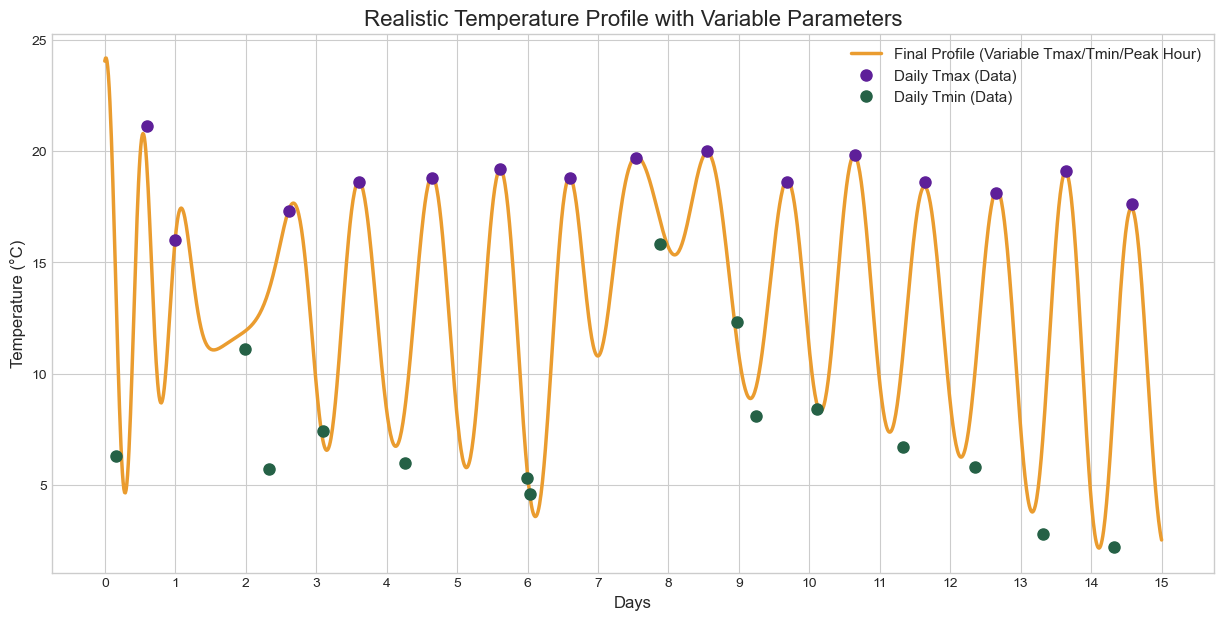

In [27]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# --- 1. INPUT DATA ---
total_days = 15
# Now we provide the maximum and minimum temperatures for each of the total_days.
T_daily_maximas = temp_df['tmax_C'].to_numpy()[0:total_days]
T_daily_minimas = temp_df['tmin_C'].to_numpy()[0:total_days]
# A list with the peak temperature hour for each day.
daily_peak_hours = temp_df['hora_tmax'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60)
daily_peak_hours = daily_peak_hours.to_numpy()[0:total_days]

# --- 2. CALCULATION OF DAILY PARAMETERS ---
T_calculated_means = (T_daily_maximas + T_daily_minimas) / 2
Calculated_Amplitudes = (T_daily_maximas - T_daily_minimas) / 2
# We calculate the phase shift 'phi' for each day.
Calculated_Phis = daily_peak_hours - 6

# --- 3. CREATION OF SMOOTH BASELINES (THREE SPLINES) ---
x_midpoints = np.arange(total_days) + 0.5

# Spline for the mean temperature
mean_spline = CubicSpline(x_midpoints, T_calculated_means, bc_type='natural')
# Spline for the amplitude
amplitude_spline = CubicSpline(x_midpoints, Calculated_Amplitudes, bc_type='natural')
# Spline for the phase shift 'phi'
phi_spline = CubicSpline(x_midpoints, Calculated_Phis, bc_type='natural')

# Generate a high-resolution time scale
continuous_t = np.linspace(0, total_days, total_days * 24 * 4) # More points for greater smoothness

# Calculate the continuous values for the three parameters
T_smooth_base = mean_spline(continuous_t)
A_smooth = amplitude_spline(continuous_t)
phi_smooth = phi_spline(continuous_t)

# --- 4. ADD THE DAILY VARIATION (WITH VARIABLE PARAMETERS) ---
hours_of_day = (continuous_t * 24) % 24
# The formula now uses the phi_smooth which varies over time
T_daily_variation = A_smooth * np.sin( (2 * np.pi / 24) * (hours_of_day - phi_smooth) )

# --- 5. OBTAIN THE FINAL AMBIENT TEMPERATURE ---
T_final_ambient = T_smooth_base + T_daily_variation

# --- 6. VISUALIZATION OF RESULTS ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))

# Final profile
ax.plot(continuous_t, T_final_ambient, 
        label='Final Profile (Variable Tmax/Tmin/Peak Hour)', 
        color='#EA9C2F', 
        linewidth=2.5)

# Original Tmax and Tmin points for verification
time_min = (temp_df['hora_tmin'].apply(parse_time_to_fraction) + temp_df.index).to_numpy()[0:total_days]
time_max = (temp_df['hora_tmax'].apply(parse_time_to_fraction) + temp_df.index).to_numpy()[0:total_days]
ax.plot(time_max, T_daily_maximas, 'o', color='#5E1F99', markersize=8, label='Daily Tmax (Data)')
ax.plot(time_min, T_daily_minimas, 'o', color='#256146', markersize=8, label='Daily Tmin (Data)')

ax.set_title('Realistic Temperature Profile with Variable Parameters', fontsize=16)
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True)
ax.set_xticks(np.arange(total_days + 1))
plt.show()

Consider the true thermal amplitude for each of the days, that is, only a cubic spline with the average temperature of the days. The time of maximum temperature is left as constant throughout the days.

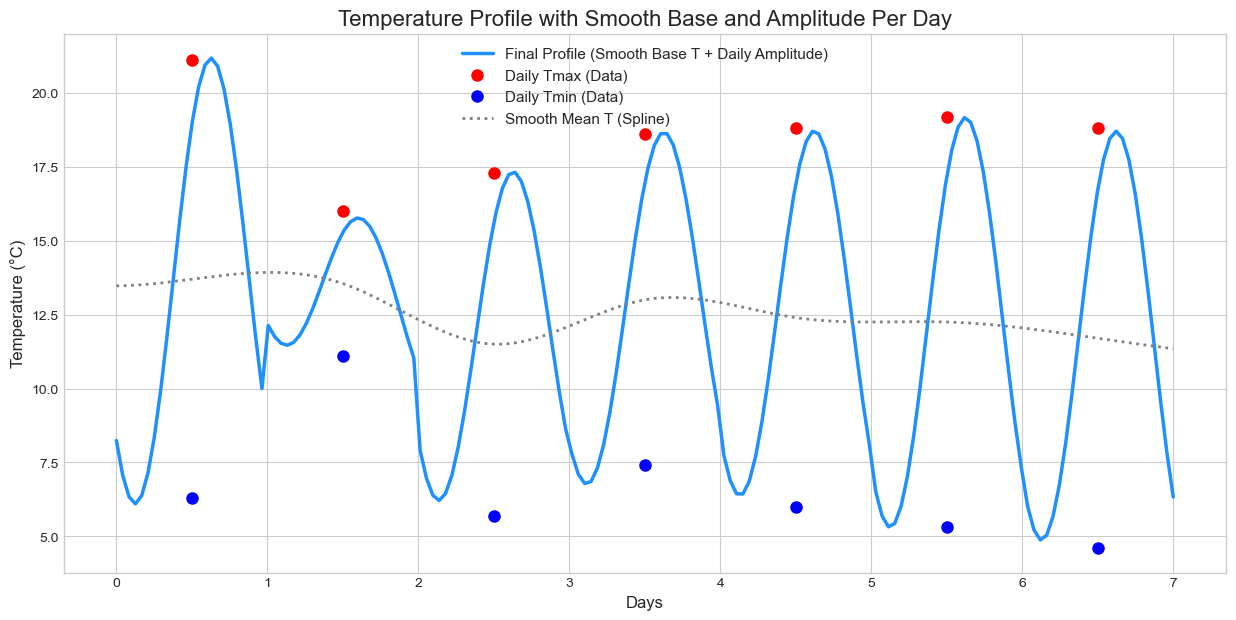

In [28]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# --- 1. INPUT DATA ---
total_days = 7
# Now we provide the maximum and minimum temperatures for each of the total_days.
T_daily_maximas = temp_df['tmax_C'].to_numpy()[0:total_days]
T_daily_minimas = temp_df['tmin_C'].to_numpy()[0:total_days]

# --- 2. PHYSICAL MODEL PARAMETERS ---
peak_temperature_hour = 15.0 # 3 PM

# --- 3. CALCULATION OF DAILY MEANS AND AMPLITUDES ---
T_calculated_means = (T_daily_maximas + T_daily_minimas) / 2
Calculated_Amplitudes = (T_daily_maximas - T_daily_minimas) / 2

# --- 4. CREATION OF THE SMOOTH BASELINE (ONLY ONE SPLINE) ---
x_midpoints = np.arange(total_days) + 0.5

# Spline for the mean temperature (this ensures continuity)
mean_spline = CubicSpline(x_midpoints, T_calculated_means, bc_type='natural')

# Generate a high-resolution time scale
continuous_t = np.linspace(0, total_days, total_days * 24)

# Calculate the continuous base temperature
T_smooth_base = mean_spline(continuous_t)

# --- 5. ASSIGN THE CORRESPONDING DAILY AMPLITUDE (WITHOUT SMOOTHING) ---
# For each point in continuous_t, we determine which day it belongs to
# and assign the calculated amplitude for that day.
day_indices = np.floor(continuous_t).astype(int)
# We ensure that the last point does not go out of the index range
day_indices = np.clip(day_indices, 0, total_days - 1)

# Create the amplitude array with a constant value for each day
A_per_day = Calculated_Amplitudes[day_indices]

# --- 6. ADD THE SINUSOIDAL DAILY VARIATION ---
phi = peak_temperature_hour - 6
hours_of_day = (continuous_t * 24) % 24
T_daily_variation = A_per_day * np.sin( (2 * np.pi / 24) * (hours_of_day - phi) )

# --- 7. OBTAIN THE FINAL AMBIENT TEMPERATURE ---
T_final_ambient = T_smooth_base + T_daily_variation

# --- 8. VISUALIZATION OF RESULTS ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))

# Final profile
ax.plot(continuous_t, T_final_ambient, '-', 
        label='Final Profile (Smooth Base T + Daily Amplitude)', 
        color='dodgerblue', 
        linewidth=2.5)

# Original Tmax and Tmin points
ax.plot(x_midpoints, T_daily_maximas, 'o', color='red', markersize=8, label='Daily Tmax (Data)')
ax.plot(x_midpoints, T_daily_minimas, 'o', color='blue', markersize=8, label='Daily Tmin (Data)')

# Baseline curve for reference
ax.plot(continuous_t, T_smooth_base, 
        label='Smooth Mean T (Spline)', 
        color='gray', 
        linestyle=':', 
        linewidth=2)

ax.set_title('Temperature Profile with Smooth Base and Amplitude Per Day', fontsize=16)
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True)
ax.set_xticks(np.arange(total_days + 1))
plt.show()

Finally, two cubic splines: mean temperature, amplitude. In addition, we consider that the heating time (from Tmin to Tmax) and cooling time (vice versa) is asymmetric for the day. For this, depending on whether it is heating or cooling, there is a different sinusoidal function.

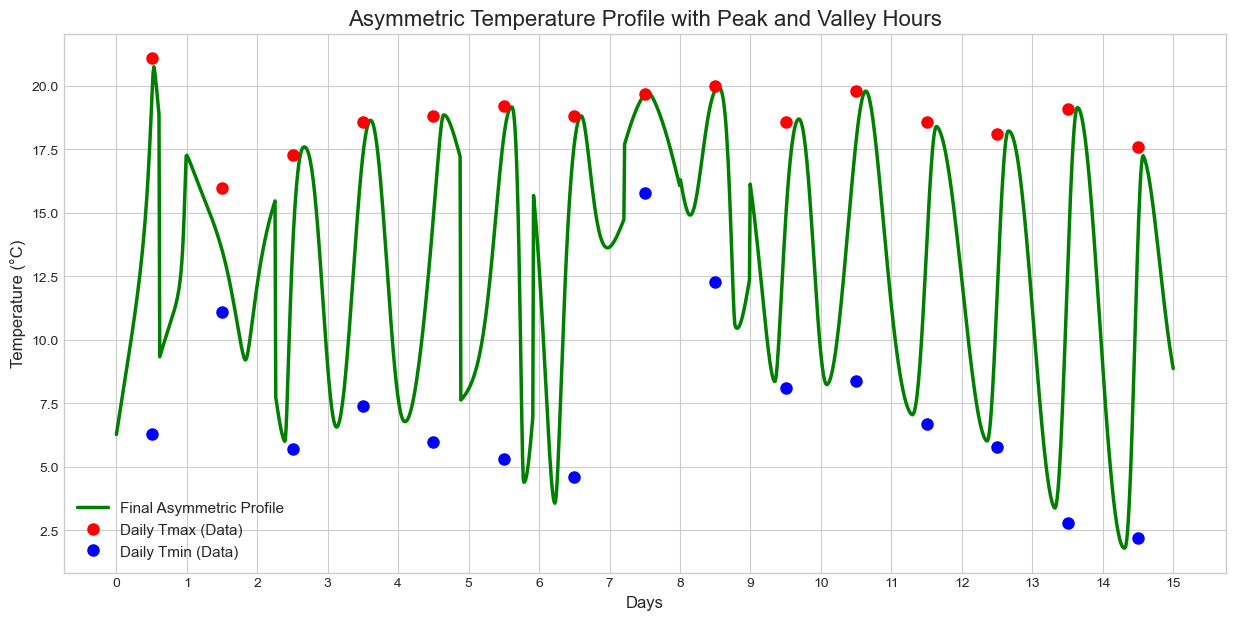

In [29]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# --- 1. INPUT DATA ---
total_days = 15
# Now we provide the maximum and minimum temperatures for each of the total_days.
T_daily_maximas = temp_df['tmax_C'].to_numpy()[0:total_days]
T_daily_minimas = temp_df['tmin_C'].to_numpy()[0:total_days]
# A list with the maximum temperature peak hour for each day.
daily_max_peak_hours = temp_df['hora_tmax'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60)
daily_max_peak_hours = daily_max_peak_hours.to_numpy()[0:total_days]
# Minimum temperature peak hour for each day (usually just before sunrise)
daily_min_peak_hours = temp_df['hora_tmin'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60)
daily_min_peak_hours = daily_min_peak_hours.to_numpy()[0:total_days]

# --- 2. CALCULATION OF DAILY PARAMETERS ---
T_calculated_means = (T_daily_maximas + T_daily_minimas) / 2
Calculated_Amplitudes = (T_daily_maximas - T_daily_minimas) / 2

# --- 3. CREATION OF SPLINES FOR ALL VARIABLE PARAMETERS ---
# For the model to be robust, we also interpolate the parameters for the next day
# to calculate the cooling phase that crosses midnight.
x_midpoints = np.arange(total_days) + 0.5


mean_spline = CubicSpline(x_midpoints, T_calculated_means)
amplitude_spline = CubicSpline(x_midpoints, Calculated_Amplitudes)
max_h_spline = CubicSpline(x_midpoints, daily_max_peak_hours)
min_h_spline = CubicSpline(x_midpoints, daily_min_peak_hours)

# --- 4. FUNCTION TO CALCULATE TEMPERATURE AT ANY INSTANT ---
def calculate_asymmetric_temp(t):
    # Get smooth parameters for time t
    T_base = mean_spline(t)
    A = amplitude_spline(t)
    h_max = max_h_spline(t)
    h_min = min_h_spline(t)

    # Current hour of the day (0-24)
    current_hour = (t * 24) % 24

    # CASE 1: Diurnal heating cycle (the most common)
    if h_min < h_max:
        heating_duration = h_max - h_min
        cooling_duration = (24 - h_max) + h_min
        
        if h_min <= current_hour < h_max:  # Heating phase
            phase = (current_hour - h_min) / heating_duration
            return T_base - A * np.cos(np.pi * phase)
        else:  # Cooling phase
            if current_hour >= h_max:
                phase = (current_hour - h_max) / cooling_duration
            else:  # current_hour < h_min (after midnight)
                phase = ((24 - h_max) + current_hour) / cooling_duration
            return T_base + A * np.cos(np.pi * phase)
            
    # CASE 2: Nocturnal heating cycle (crosses midnight, less common, but accounted for)
    else:
        heating_duration = (24 - h_min) + h_max
        cooling_duration = h_min - h_max
        
        if h_max <= current_hour < h_min: # Cooling phase
            phase = (current_hour - h_max) / cooling_duration
            return T_base + A * np.cos(np.pi * phase)
        else: # Heating phase
            if current_hour >= h_min:
                phase = (current_hour - h_min) / heating_duration
            else: # current_hour < h_max (after midnight)
                phase = ((24 - h_min) + current_hour) / heating_duration
            return T_base - A * np.cos(np.pi * phase)

# --- 5. GENERATION OF THE TIME SERIES ---
t_continuous = np.linspace(0, total_days, total_days * 24 * 4)
T_final_ambient = np.array([calculate_asymmetric_temp(t) for t in t_continuous])

# --- 6. VISUALIZATION ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(t_continuous, T_final_ambient,
        label='Final Asymmetric Profile',
        color='green',
        linewidth=2.5)

ax.plot(x_midpoints, T_daily_maximas, 'o', color='red', markersize=8, label='Daily Tmax (Data)')
ax.plot(x_midpoints, T_daily_minimas, 'o', color='blue', markersize=8, label='Daily Tmin (Data)')

ax.set_title('Asymmetric Temperature Profile with Peak and Valley Hours', fontsize=16)
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True)
ax.set_xticks(np.arange(total_days + 1))
plt.show()

## Validation of the chosen model over real data

In [30]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [31]:
fich = pd.read_json('/Users/alzorrcarri/Documents/resisto_synth/synthetic_model/temperature_ambience/data.json')

In [32]:
fich = fich.drop(columns=['idema', 'lon', 'prec', 'alt', 'vmax', 'vv', 'dv', 'lat', 'dmax', 'ubi', 'hr'])

In [33]:
fich['fint'] = pd.to_datetime(fich['fint'])
fich['day'] = fich['fint'].dt.date
fich['hour'] = fich['fint'].dt.hour

In [34]:
fich.head()

,fint,tamin,ta,tamax,day,hour
0,2025-11-24 00:00:00+00:00,6.7,6.7,7.1,2025-11-24,0
1,2025-11-24 01:00:00+00:00,6.7,7.3,7.3,2025-11-24,1
2,2025-11-24 02:00:00+00:00,7.1,7.4,7.8,2025-11-24,2
3,2025-11-24 03:00:00+00:00,7.3,7.3,7.6,2025-11-24,3
4,2025-11-24 04:00:00+00:00,6.2,6.2,7.2,2025-11-24,4


In [35]:
daily_stats = []
for day, group in fich.groupby('day'):
    tmax_row = group.loc[group['ta'].idxmax()]
    tmin_row = group.loc[group['ta'].idxmin()]
    daily_stats.append({
        'day': day,
        'tmax': tmax_row['ta'],
        'hour_tmax': tmax_row['hour'],
        'tmin': tmin_row['ta'],
        'hour_tmin': tmin_row['hour']
    })
daily_temps = pd.DataFrame(daily_stats)

In [36]:
daily_temps.head()

,day,tmax,hour_tmax,tmin,hour_tmin
0,2025-11-24,11.6,13,5.8,7
1,2025-11-25,14.9,15,7.0,23
2,2025-11-26,14.4,15,2.0,7
3,2025-11-27,15.0,15,0.8,6
4,2025-11-28,15.0,15,1.8,7


/var/folders/lp/8xhvbnh90j7366cnys2gjhq00000gn/T/ipykernel_14737/3283843565.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2025-11-24 00:00', '2025-11-25 00:00', '2025-11-26 00:00', '2025-11-27 00:00', '2025-11-28 00:00', '2025-11-29 00:00', '2025-11-30 00:00', '2025-12-01 00:00'],
/var/folders/lp/8xhvbnh90j7366cnys2gjhq00000gn/T/ipykernel_14737/3283843565.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


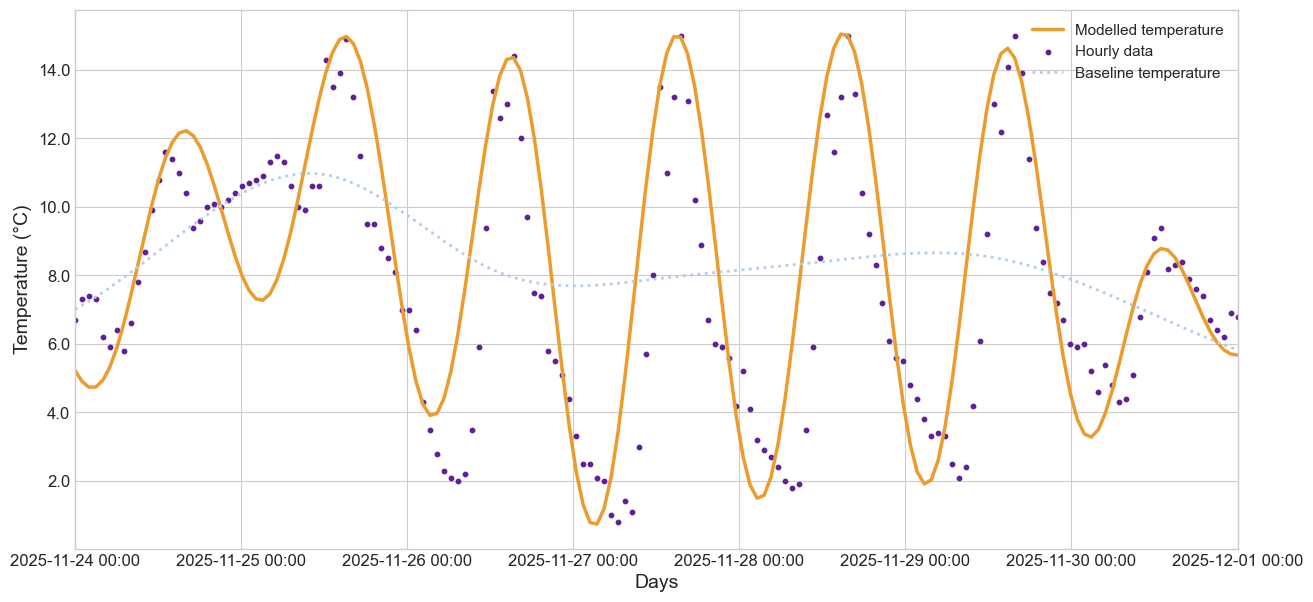

In [37]:
dias_totales = len(daily_temps)
T_maximas_diarias = daily_temps['tmax'].to_numpy()
T_minimas_diarias = daily_temps['tmin'].to_numpy()

hora_pico_temperatura = 15.0 #  3 PM
T_medias_calculadas = (T_maximas_diarias + T_minimas_diarias) / 2
Amplitudes_calculadas = (T_maximas_diarias - T_minimas_diarias) / 2

x_puntos_medios = np.arange(dias_totales) + 0.5
spline_media = CubicSpline(x_puntos_medios, T_medias_calculadas, bc_type='natural')
spline_amplitud = CubicSpline(x_puntos_medios, Amplitudes_calculadas, bc_type='natural')

t_continuo = np.linspace(0, dias_totales, dias_totales * 24)

T_base_suave = spline_media(t_continuo)
A_suave = spline_amplitud(t_continuo)

phi = hora_pico_temperatura - 6
horas_del_dia = (t_continuo * 24) % 24
T_variacion_diaria = A_suave * np.sin( (2 * np.pi / 24) * (horas_del_dia - phi) )

T_ambiente_final = T_base_suave + T_variacion_diaria



plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(t_continuo, T_ambiente_final, 
        label='Modelled temperature', 
        color='#EA9C2F', 
        linewidth=2.5)

ax.scatter(t_continuo, fich['ta'], color='#5E1F99', s=10, label='Hourly data')

ax.plot(t_continuo, T_base_suave, 
        label='Baseline temperature', 
        color='#B3CDEA', 
        linestyle=':', 
        linewidth=2)

ax.set_xlabel('Days', fontsize=14)
ax.set_xlim(0, dias_totales)
ax.set_ylabel('Temperature (°C)', fontsize=14)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True)
ax.set_xticklabels(['2025-11-24 00:00', '2025-11-25 00:00', '2025-11-26 00:00', '2025-11-27 00:00', '2025-11-28 00:00', '2025-11-29 00:00', '2025-11-30 00:00', '2025-12-01 00:00'],
                   fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)

# plt.savefig('/Users/alzorrcarri/Documents/resisto_synth/synthetic_model/temperature_ambience/val_modelo_tmp.pdf', dpi=300)
plt.show()
